In [1]:
# libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, homogeneity_completeness_v_measure
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from folium.plugins import HeatMap
from kneed import KneeLocator

In [2]:
# import data
wrangled = pd.read_csv('../data/processed/dog_bite_wrangled.csv')

# display
wrangled.head()

,date_of_bite,year,month,day,day_of_week,borough,zip_code,latitude,longitude,spay_neuter,...,pit_bull,german_shepherd,shih_tzu,chihuahua,yorkshire_terrier,bull_dog,labrador_retriever,maltese,husky,standard_poodle
0,2018-01-01,2018,1,1,0,brooklyn,11220,40.641026,-74.016688,False,...,False,False,False,False,False,False,False,False,False,False
1,2018-01-06,2018,1,6,5,brooklyn,11224,40.577372,-73.988706,False,...,True,False,False,False,False,False,False,False,False,False
2,2018-01-08,2018,1,8,0,brooklyn,11231,40.677916,-74.005154,False,...,False,False,False,False,False,False,False,False,False,False
3,2018-01-09,2018,1,9,1,brooklyn,11224,40.577372,-73.988706,False,...,True,False,False,False,False,False,False,False,False,False
4,2018-01-03,2018,1,3,2,brooklyn,11231,40.677916,-74.005154,False,...,False,False,False,False,False,False,False,False,False,False


In [3]:
# drop other data
feats_to_keep = ['date_of_bite', 'borough']
prep_final = wrangled[feats_to_keep]

prep_final.head()

,date_of_bite,borough
0,2018-01-01,brooklyn
1,2018-01-06,brooklyn
2,2018-01-08,brooklyn
3,2018-01-09,brooklyn
4,2018-01-03,brooklyn


In [4]:
df = prep_final.copy()

In [5]:
df['date_of_bite'] = pd.to_datetime(df['date_of_bite'])
df['year_week'] = df['date_of_bite'].dt.strftime('%Y-%U')

df.head()

,date_of_bite,borough,year_week
0,2018-01-01,brooklyn,2018-00
1,2018-01-06,brooklyn,2018-00
2,2018-01-08,brooklyn,2018-01
3,2018-01-09,brooklyn,2018-01
4,2018-01-03,brooklyn,2018-00


In [6]:
weekly_trends = df.groupby(['borough', 'year_week']).size().reset_index(name='bite_count')

weekly_trends.head()

,borough,year_week,bite_count
0,bronx,2015-00,1
1,bronx,2015-01,2
2,bronx,2015-02,7
3,bronx,2015-03,8
4,bronx,2015-04,7


In [7]:
pivot_data = weekly_trends.pivot(index='borough', columns='year_week', values='bite_count').fillna(0)

pivot_data.head()

year_week,2015-00,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,...,2022-43,2022-44,2022-45,2022-46,2022-47,2022-48,2022-49,2022-50,2022-51,2022-52
borough,,,,,,,,,,,,,,,,,,,,,
bronx,1.0,2.0,7.0,8.0,7.0,12.0,6.0,5.0,9.0,3.0,...,6.0,12.0,13.0,5.0,11.0,13.0,7.0,9.0,5.0,13.0
brooklyn,6.0,10.0,6.0,5.0,7.0,10.0,12.0,9.0,12.0,6.0,...,8.0,9.0,7.0,9.0,9.0,6.0,7.0,7.0,6.0,5.0
manhattan,2.0,9.0,5.0,10.0,4.0,8.0,10.0,6.0,5.0,12.0,...,7.0,15.0,11.0,3.0,4.0,13.0,9.0,5.0,8.0,2.0
queens,3.0,8.0,5.0,9.0,4.0,8.0,6.0,10.0,8.0,12.0,...,14.0,12.0,11.0,4.0,5.0,8.0,13.0,9.0,7.0,14.0
staten island,2.0,3.0,4.0,3.0,4.0,6.0,3.0,8.0,2.0,6.0,...,7.0,5.0,5.0,3.0,3.0,1.0,3.0,2.0,3.0,1.0


In [8]:
n_lags = 5  # Choose `n_lags` based on your needs

lagged_data = pivot_data.copy()

for lag in range(1, n_lags + 1):
    shifted = pivot_data.shift(lag, axis=1)
    shifted.columns = [f'lag_{lag}_{col}' for col in shifted.columns]
    lagged_data = pd.concat([lagged_data, shifted], axis=1)

# Drop the original columns
lagged_data = lagged_data.iloc[:, pivot_data.shape[1]:]

lagged_data.head()

,lag_1_2015-00,lag_1_2015-01,lag_1_2015-02,lag_1_2015-03,lag_1_2015-04,lag_1_2015-05,lag_1_2015-06,lag_1_2015-07,lag_1_2015-08,lag_1_2015-09,...,lag_5_2022-43,lag_5_2022-44,lag_5_2022-45,lag_5_2022-46,lag_5_2022-47,lag_5_2022-48,lag_5_2022-49,lag_5_2022-50,lag_5_2022-51,lag_5_2022-52
borough,,,,,,,,,,,,,,,,,,,,,
bronx,NaN,1.0,2.0,7.0,8.0,7.0,12.0,6.0,5.0,9.0,...,7.0,8.0,7.0,7.0,9.0,6.0,12.0,13.0,5.0,11.0
brooklyn,NaN,6.0,10.0,6.0,5.0,7.0,10.0,12.0,9.0,12.0,...,6.0,9.0,7.0,9.0,14.0,8.0,9.0,7.0,9.0,9.0
manhattan,NaN,2.0,9.0,5.0,10.0,4.0,8.0,10.0,6.0,5.0,...,11.0,5.0,7.0,5.0,7.0,7.0,15.0,11.0,3.0,4.0
queens,NaN,3.0,8.0,5.0,9.0,4.0,8.0,6.0,10.0,8.0,...,12.0,11.0,12.0,7.0,13.0,14.0,12.0,11.0,4.0,5.0
staten island,NaN,2.0,3.0,4.0,3.0,4.0,6.0,3.0,8.0,2.0,...,4.0,7.0,3.0,7.0,11.0,7.0,5.0,5.0,3.0,3.0


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(lagged_data.dropna(axis=1))  # Drop NaN columns if applicable

normalized_data = pd.DataFrame(normalized_data, columns=lagged_data.dropna(axis=1).columns)

normalized_data.head()

,lag_1_2015-01,lag_1_2015-02,lag_1_2015-03,lag_1_2015-04,lag_1_2015-05,lag_1_2015-06,lag_1_2015-07,lag_1_2015-08,lag_1_2015-09,lag_1_2015-10,...,lag_5_2022-43,lag_5_2022-44,lag_5_2022-45,lag_5_2022-46,lag_5_2022-47,lag_5_2022-48,lag_5_2022-49,lag_5_2022-50,lag_5_2022-51,lag_5_2022-52
0,-1.046229,-1.348907,1.568929,0.383482,1.224745,1.568929,-0.4375,-1.401826,0.524891,-1.333333,...,-0.329690,0.0,-0.070014,0.000000,-0.702782,-0.836080,0.413919,1.224745,0.089803,1.497172
1,1.859962,1.103651,0.588348,-0.766965,1.224745,0.588348,1.4375,0.754829,1.399708,-0.500000,...,-0.659380,0.5,-0.070014,1.581139,1.249390,-0.139347,-0.473050,-0.816497,1.885856,0.846228
2,-0.464991,0.797081,-0.392232,1.150447,-0.816497,-0.392232,0.8125,-0.862662,-0.641533,1.166667,...,0.989071,-1.5,-0.070014,-1.581139,-1.483651,-0.487713,1.300887,0.544331,-0.808224,-0.781133
3,0.116248,0.490511,-0.392232,0.766965,-0.816497,-0.392232,-0.4375,1.293993,0.233285,1.166667,...,1.318761,1.5,1.680336,0.000000,0.858956,1.950852,0.413919,0.544331,-0.359211,-0.455661
4,-0.464991,-1.042337,-1.372813,-1.533930,-0.816497,-1.372813,-1.3750,0.215666,-1.516351,-0.500000,...,-1.318761,-0.5,-1.470294,0.000000,0.078087,-0.487713,-1.655675,-1.496910,-0.808224,-1.106606


In [10]:
from sklearn.cluster import KMeans

# Merge weekly_trends with pivot_data to ensure consistent sample sizes
merged_data = weekly_trends.merge(pivot_data.reset_index(), on='borough')

for n_clusters in range(2, 5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(normalized_data)
    pivot_data[f'{n_clusters}_clustering'] = clusters
    
    # print the clustering of boroughs
    print(pivot_data[f'{n_clusters}_clustering'].value_counts())
    
    # print the silhouette score
    silhouette_avg = silhouette_score(normalized_data, clusters)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")
    
    # print the davies bouldin score
    db_score = davies_bouldin_score(normalized_data, clusters)
    print(f"Davies Bouldin Score for {n_clusters} clusters: {db_score}")
    
    # print the homogeneity, completeness, and v-measure
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(merged_data['borough'][:len(clusters)], clusters)
    print(f"Homogeneity: {homogeneity}")
    print(f"Completeness: {completeness}")
    print(f"V-Measure: {v_measure}")
    
    # print the adjusted rand score
    rand_score = adjusted_rand_score(merged_data['borough'][:len(clusters)], clusters)
    print(f"Adjusted Rand Score: {rand_score}")
    
    # print the inertia
    print(f"Inertia for {n_clusters} clusters: {kmeans.inertia_}")

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2_clustering
0    4
1    1
Name: count, dtype: int64
Silhouette Score for 2 clusters: 0.19568801836331057
Davies Bouldin Score for 2 clusters: 0.4957114144340098
Homogeneity: 1.0
Completeness: 0.0
V-Measure: 0.0
Adjusted Rand Score: 0.0
Inertia for 2 clusters: 5805.722762560801
3_clustering
2    2
0    2
1    1
Name: count, dtype: int64
Silhouette Score for 3 clusters: 0.12430940178017909
Davies Bouldin Score for 3 clusters: 0.8387529048668027
Homogeneity: 1.0
Completeness: 0.0
V-Measure: 0.0
Adjusted Rand Score: 0.0
Inertia for 3 clusters: 3049.307846073818
4_clustering
2    2
0    1
3    1
1    1
Name: count, dtype: int64
Silhouette Score for 4 clusters: 0.060179876758466214
Davies Bouldin Score for 4 clusters: 0.4466902125142345
Homogeneity: 1.0
Completeness: 0.0
V-Measure: 0.0
Adjusted Rand Score: 0.0
Inertia for 4 clusters: 1447.8884266612995


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
# Add cluster labels to the weekly_trends dataframe
weekly_trends = weekly_trends.merge(pivot_data[['3_clustering']], on='borough', how='left')

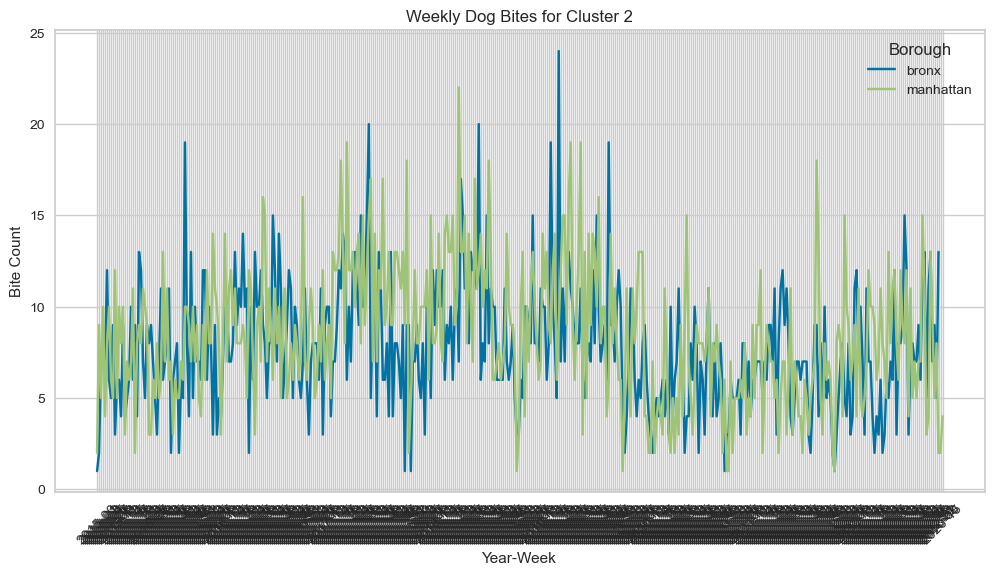

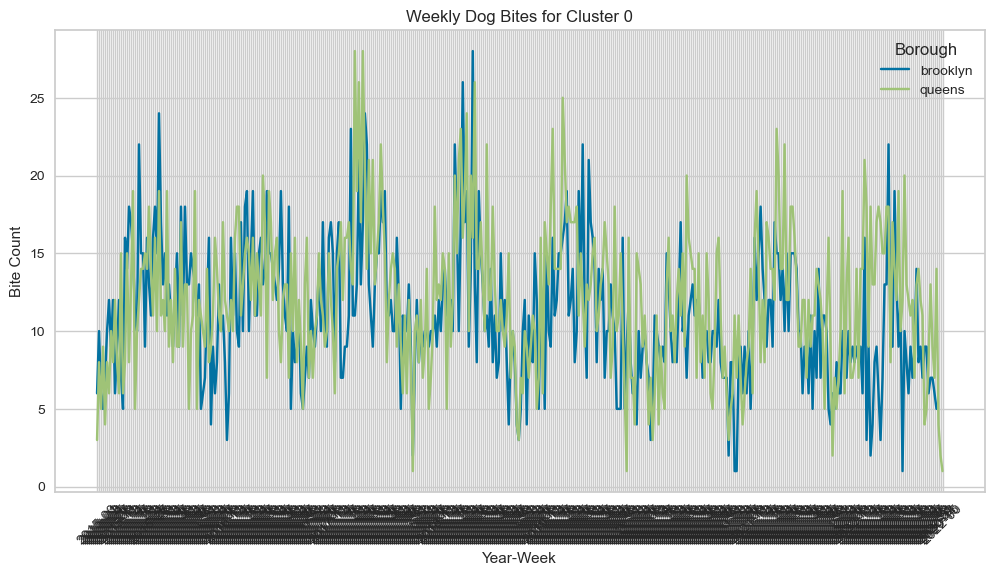

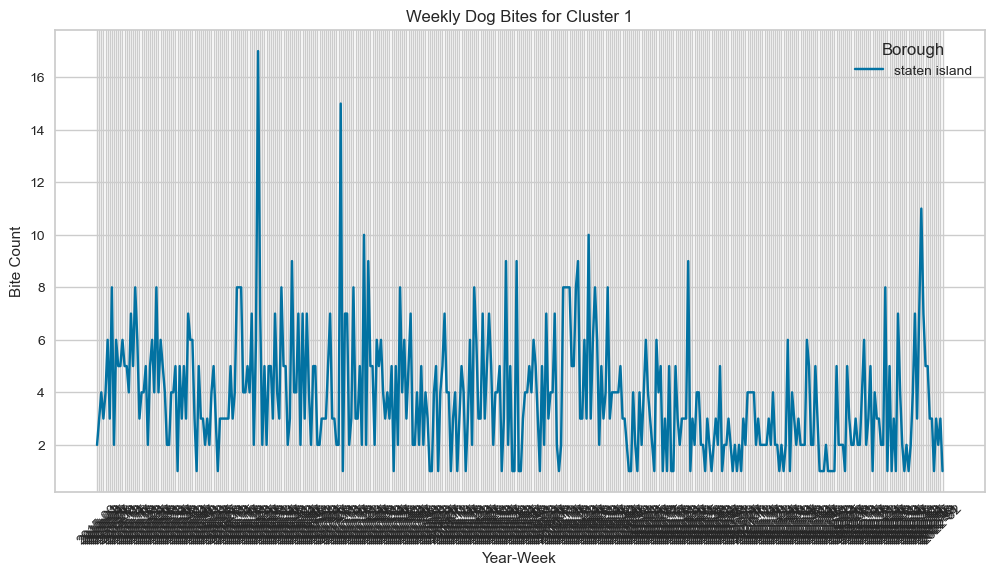

In [12]:

# Create a line plot for each cluster
for cluster in weekly_trends['3_clustering'].unique():
    plt.figure(figsize=(12, 6))
    cluster_data = weekly_trends[weekly_trends['3_clustering'] == cluster]
    sns.lineplot(data=cluster_data, x='year_week', y='bite_count', hue='borough')
    plt.title(f'Weekly Dog Bites for Cluster {cluster}')
    plt.xlabel('Year-Week')
    plt.ylabel('Bite Count')
    plt.xticks(rotation=45)
    plt.legend(title='Borough')
    plt.show()

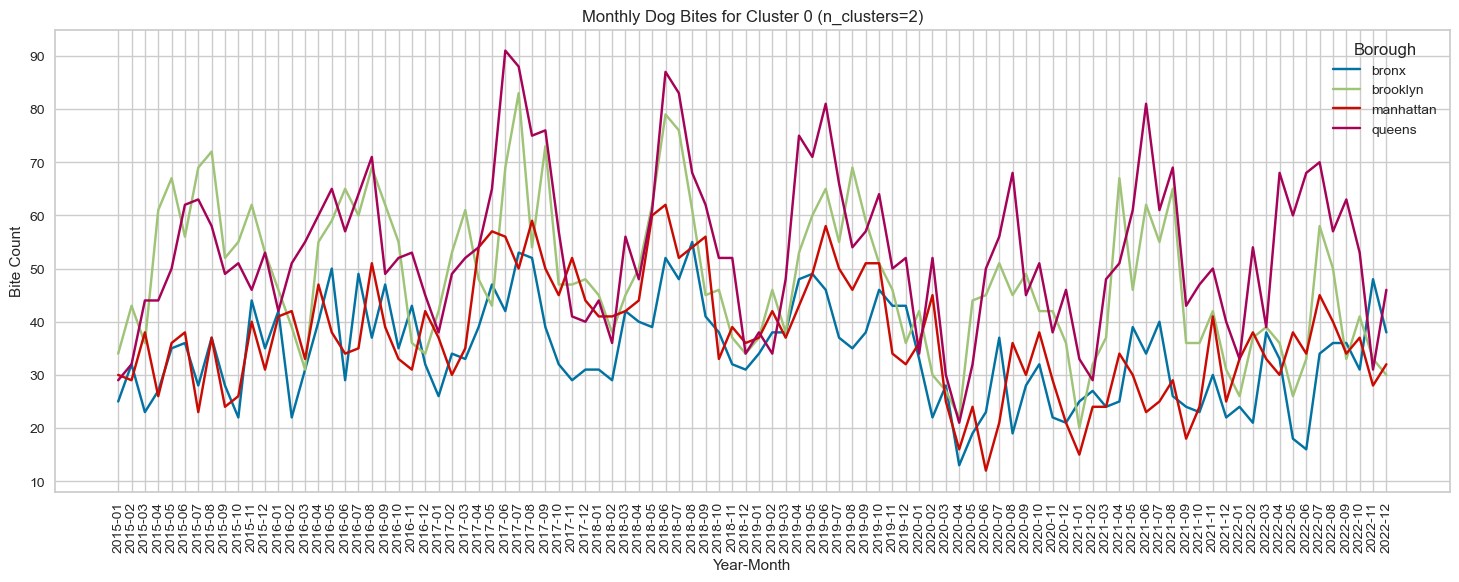

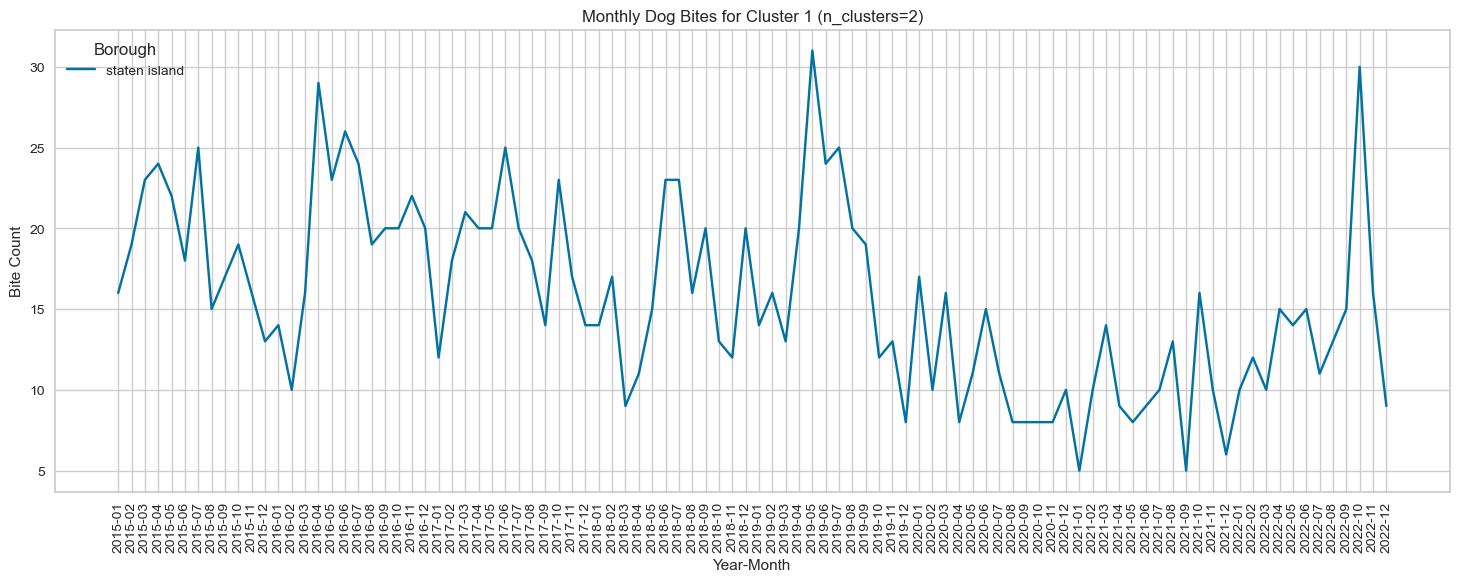

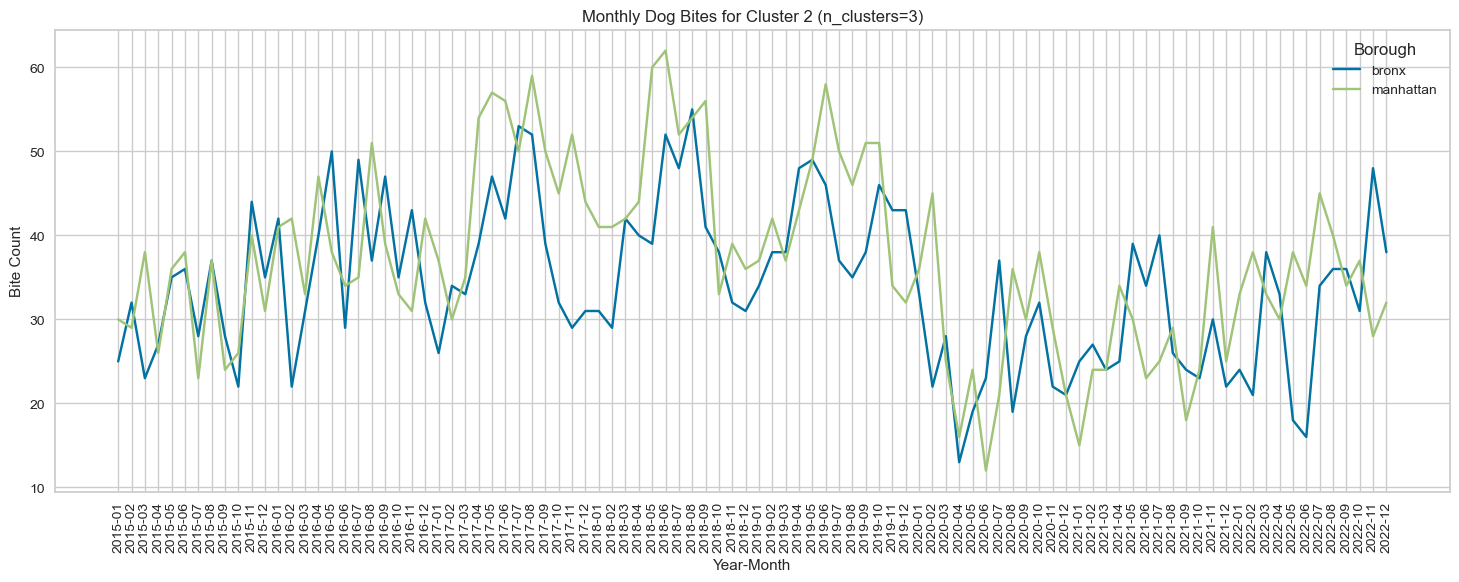

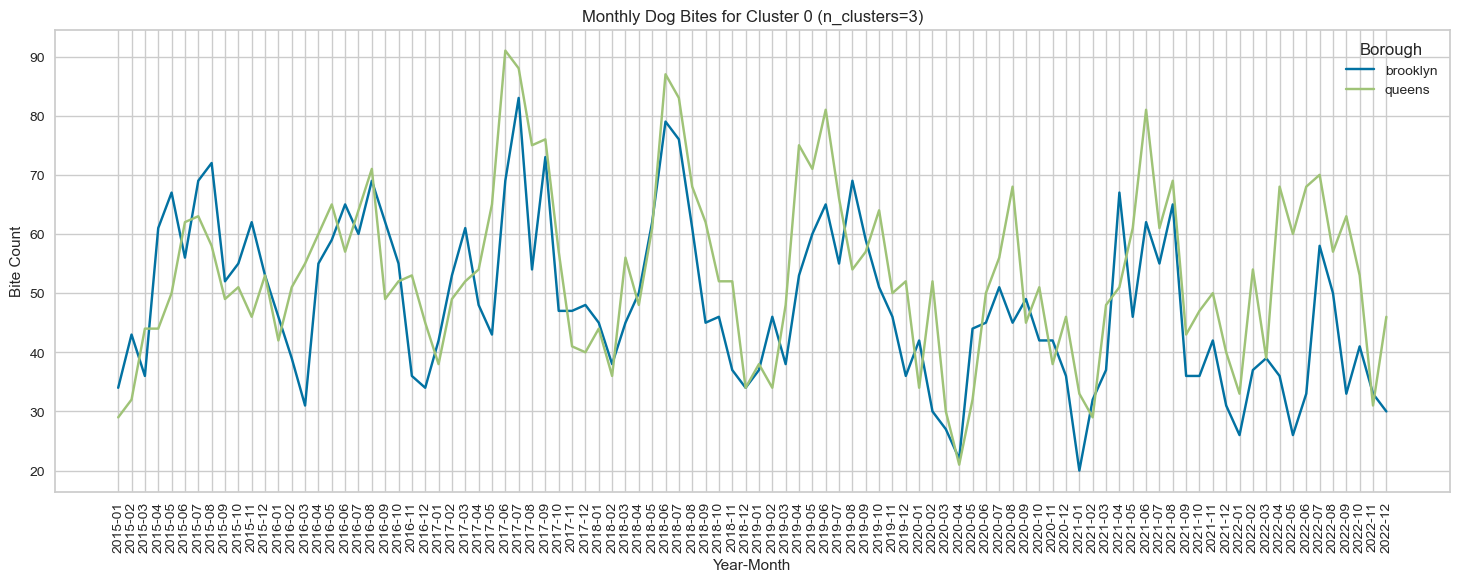

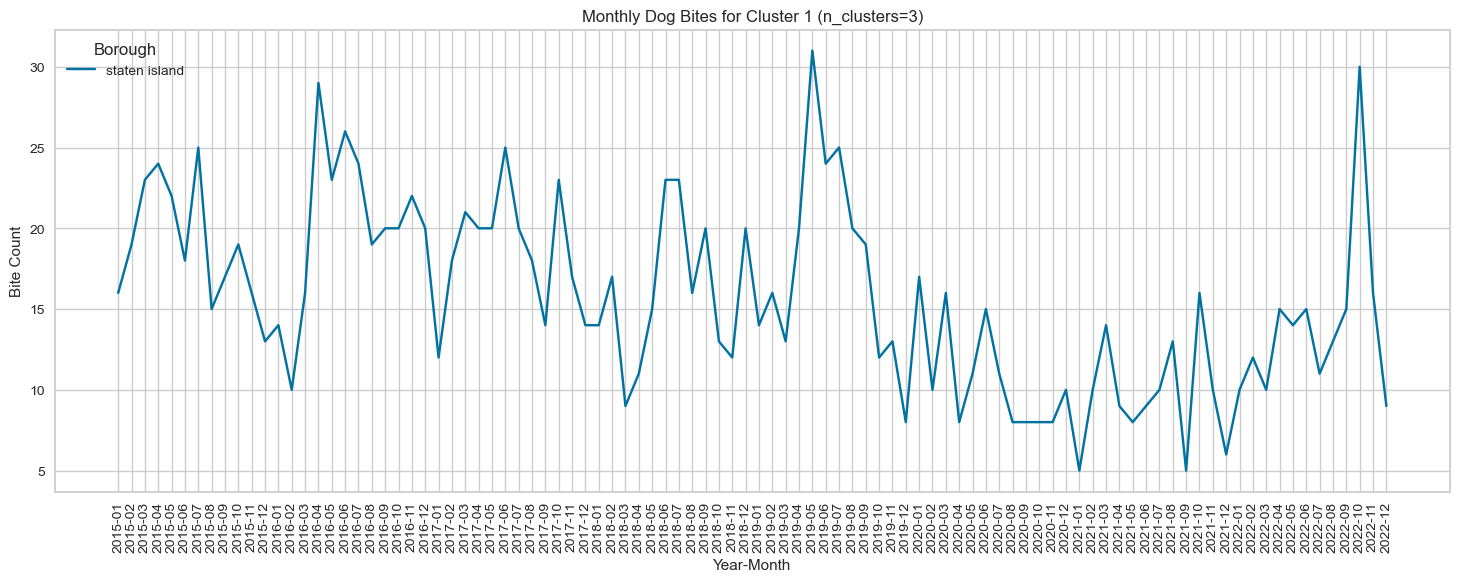

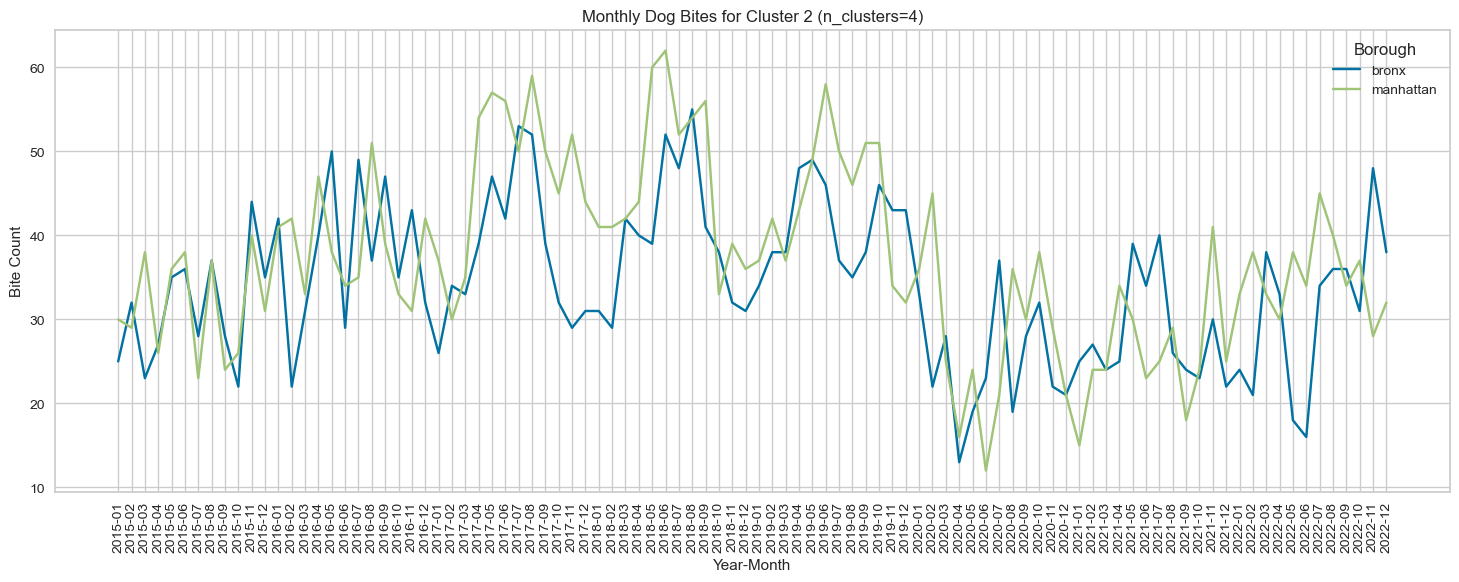

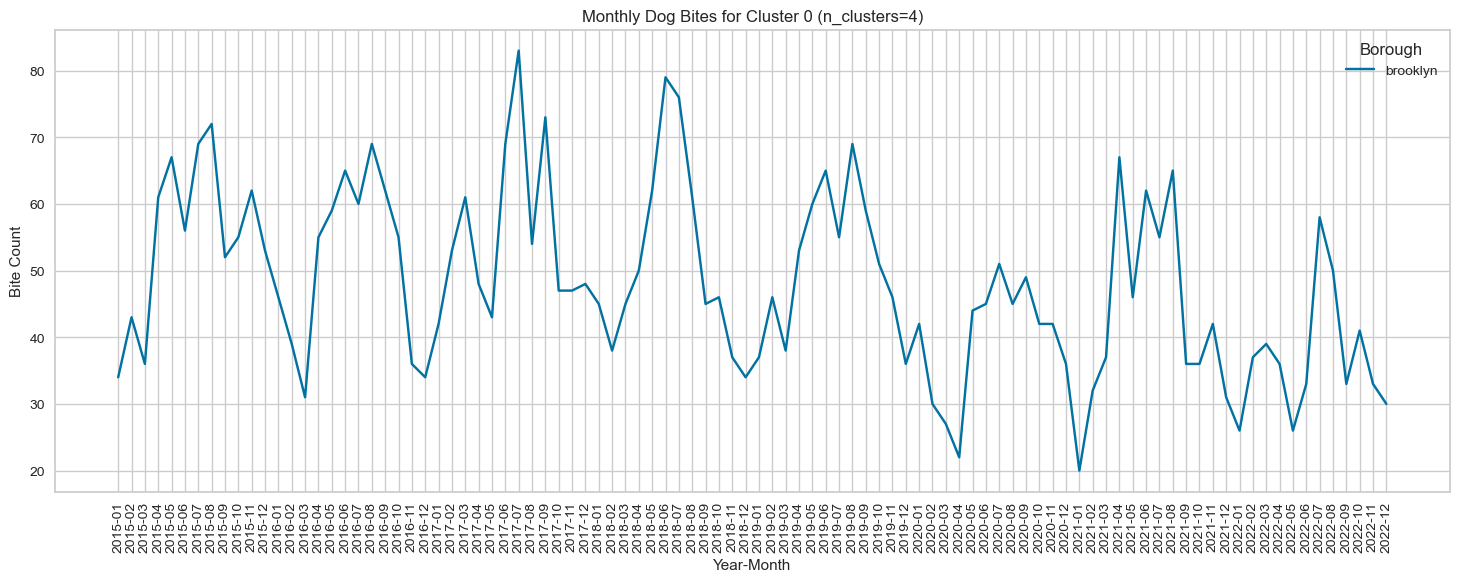

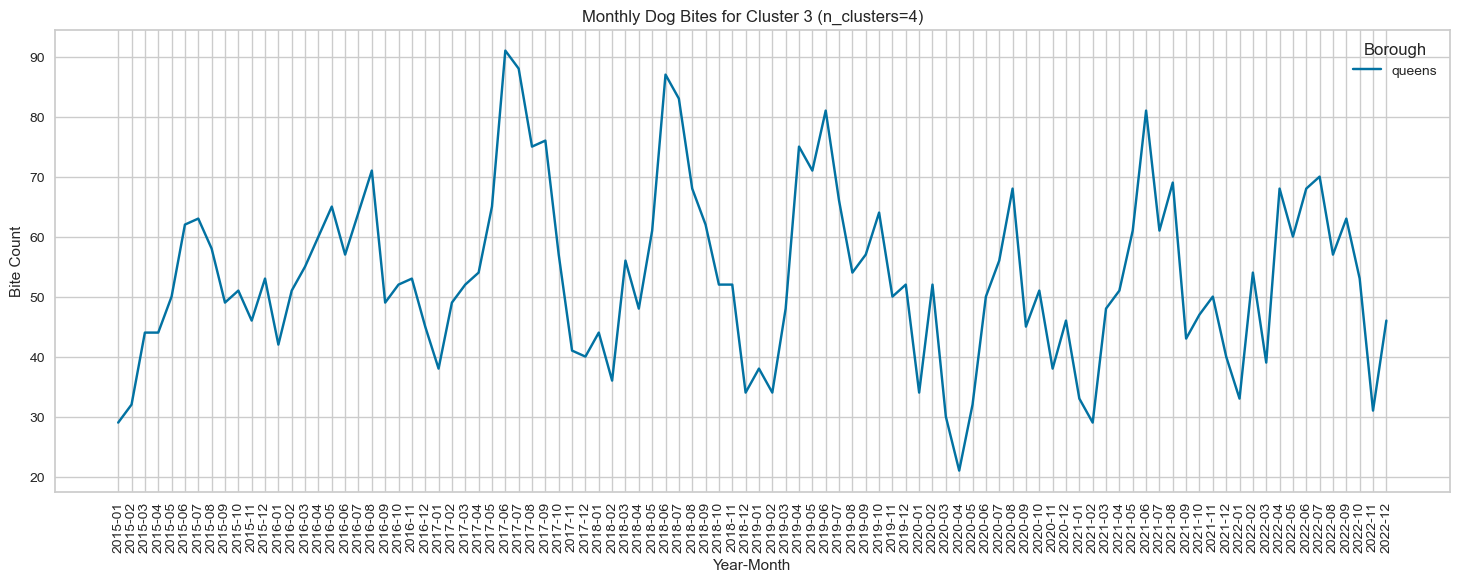

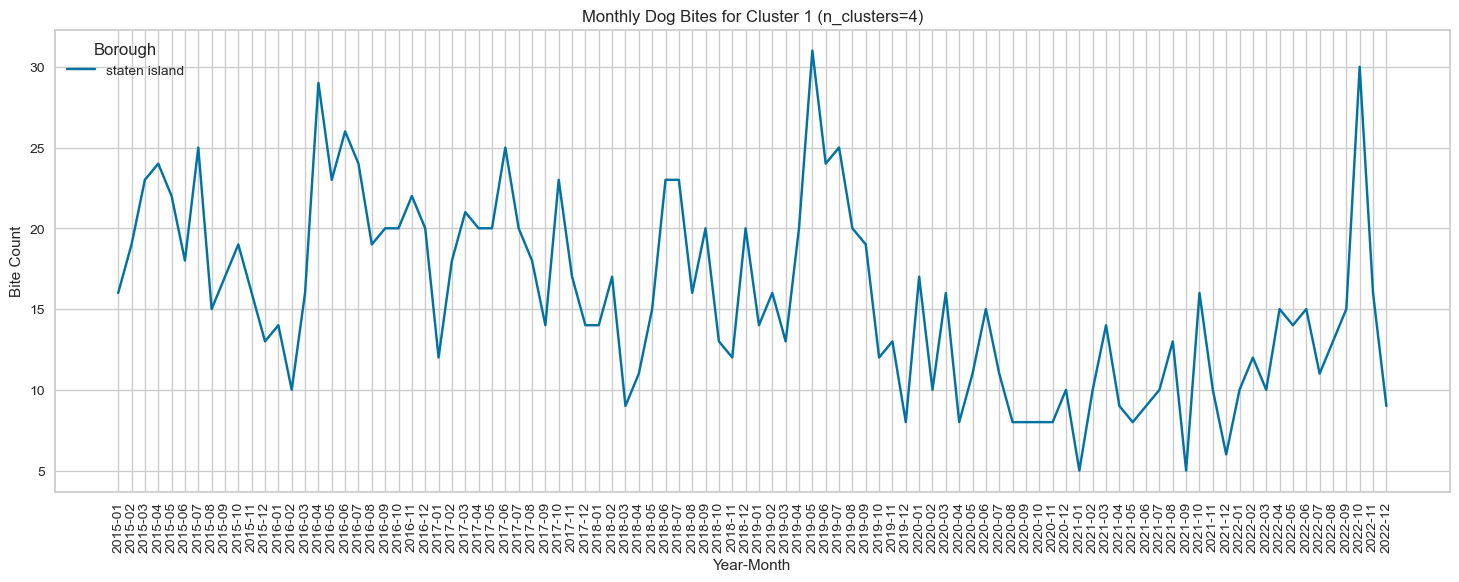

In [ ]:
# Add cluster labels to the monthly_trends dataframe
monthly_trends = df.groupby(['borough', df['date_of_bite'].dt.to_period('M')]).size().reset_index(name='bite_count')
monthly_trends['date_of_bite'] = monthly_trends['date_of_bite'].dt.strftime('%Y-%m')

# Create line plots for each value of n_clusters
for n_clusters in range(2, 5):
    cluster_col = f'{n_clusters}_clustering'
    
    # Merge cluster labels
    monthly_trends = monthly_trends.merge(pivot_data[[cluster_col]], on='borough')
    
    # Create a line plot for each cluster
    for cluster in monthly_trends[cluster_col].unique():
        plt.figure(figsize=(18, 6))
        cluster_data = monthly_trends[monthly_trends[cluster_col] == cluster]
        sns.lineplot(data=cluster_data, x='date_of_bite', y='bite_count', hue='borough')
        plt.title(f'Monthly Dog Bites for Cluster {cluster} (n_clusters={n_clusters})')
        plt.xlabel('Year-Month')
        plt.ylabel('Bite Count')
        plt.xticks(rotation=90)
        plt.legend(title='Borough')
        plt.show()

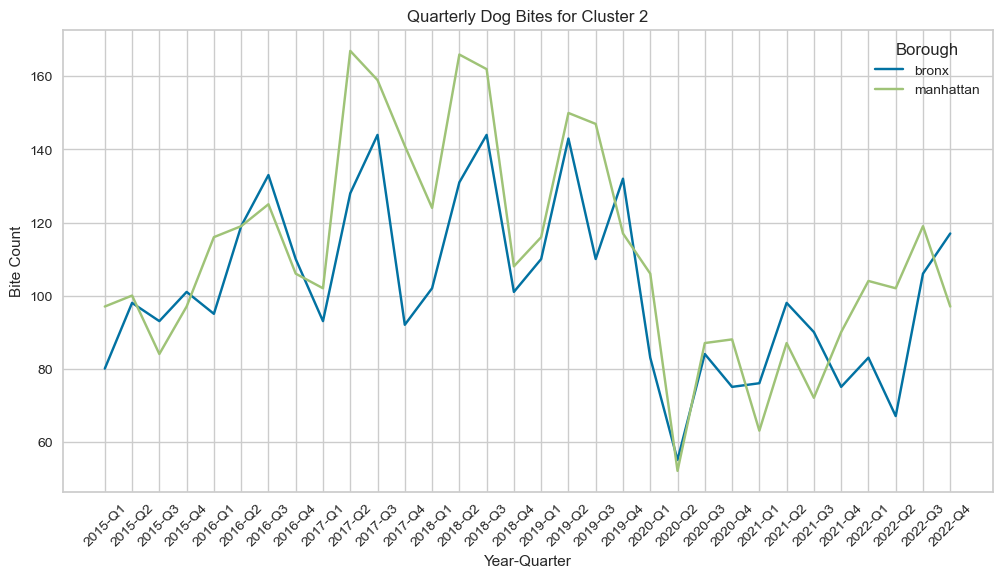

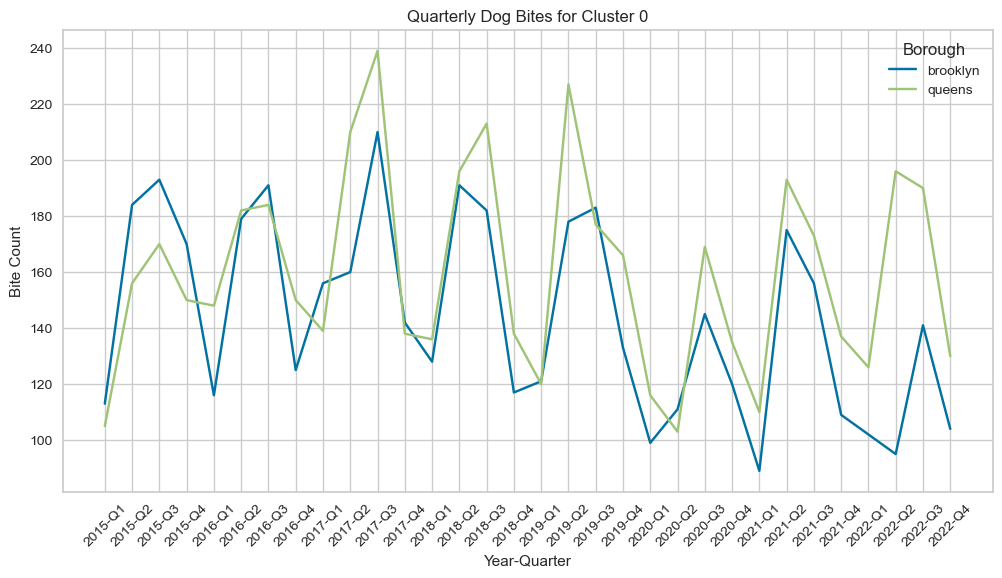

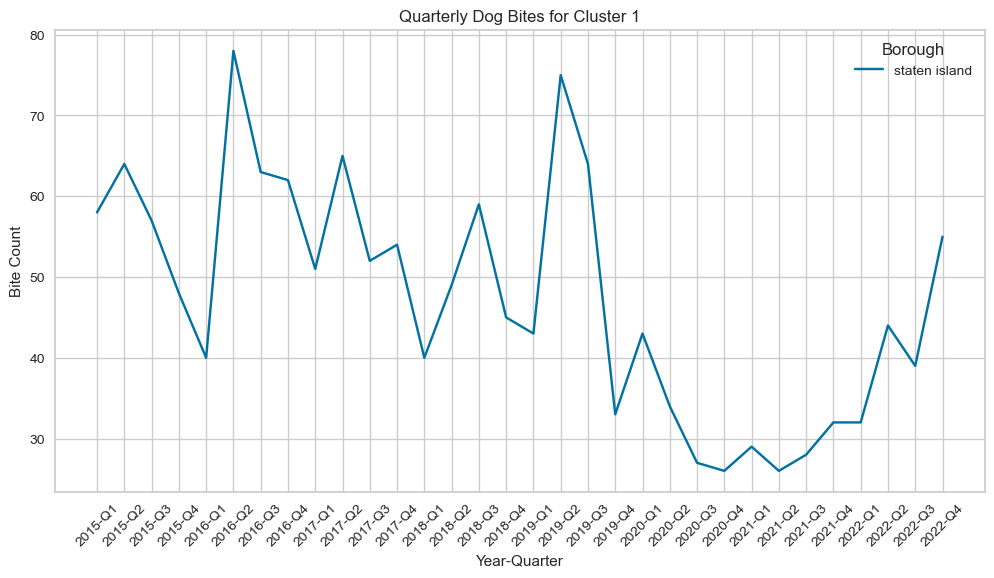

In [ ]:
# Add cluster labels to the quarterly_trends dataframe
quarterly_trends = df.groupby(['borough', df['date_of_bite'].dt.to_period('Q')]).size().reset_index(name='bite_count')
quarterly_trends['date_of_bite'] = quarterly_trends['date_of_bite'].dt.strftime('%Y-Q%q')

# Merge cluster labels
quarterly_trends = quarterly_trends.merge(pivot_data[['cluster']], on='borough')

# Create a line plot for each cluster
for cluster in quarterly_trends['cluster'].unique():
    plt.figure(figsize=(12, 6))
    cluster_data = quarterly_trends[quarterly_trends['cluster'] == cluster]
    sns.lineplot(data=cluster_data, x='date_of_bite', y='bite_count', hue='borough')
    plt.title(f'Quarterly Dog Bites for Cluster {cluster}')
    plt.xlabel('Year-Quarter')
    plt.ylabel('Bite Count')
    plt.xticks(rotation=45)
    plt.legend(title='Borough')
    plt.show()

In [13]:
# Map boroughs to clusters
cluster_mapping = {
    'staten island': 1,
    'brooklyn': 0,
    'queens': 0,
    'bronx': 2,
    'manhattan': 2
}

clustered = wrangled.copy()

# Apply the mapping to the wrangled dataframe
clustered['cluster'] = wrangled['borough'].map(cluster_mapping)

clustered.head()

,date_of_bite,year,month,day,day_of_week,borough,zip_code,latitude,longitude,spay_neuter,...,german_shepherd,shih_tzu,chihuahua,yorkshire_terrier,bull_dog,labrador_retriever,maltese,husky,standard_poodle,cluster
0,2018-01-01,2018,1,1,0,brooklyn,11220,40.641026,-74.016688,False,...,False,False,False,False,False,False,False,False,False,0
1,2018-01-06,2018,1,6,5,brooklyn,11224,40.577372,-73.988706,False,...,False,False,False,False,False,False,False,False,False,0
2,2018-01-08,2018,1,8,0,brooklyn,11231,40.677916,-74.005154,False,...,False,False,False,False,False,False,False,False,False,0
3,2018-01-09,2018,1,9,1,brooklyn,11224,40.577372,-73.988706,False,...,False,False,False,False,False,False,False,False,False,0
4,2018-01-03,2018,1,3,2,brooklyn,11231,40.677916,-74.005154,False,...,False,False,False,False,False,False,False,False,False,0


In [14]:
# export the data
clustered.to_csv('../data/processed/dog_bite_clustered.csv', index=False)